# analyze `allblocks-tobalaba.db` data; better node connectivity

calculates & plots

* blocktime
* TPS (transactions per second), over 1, 3, 5, 10 consecutive blocks
* block size
* gasUsed and gasLimit per second

It needs an `allblocks-tobalaba.db` database (created by `blocksDB_create.py`) containing all the blocks.


In this specific case the `Tobalaba` chain of the Energy Web Foundation (https://tobalaba.etherscan.com).

---

Please cite this as:

> Ethereum benchmarking scripts "chainhammer" and "chainreader"  
> by Dr Andreas Krueger, Electron.org.uk, London 2018  
> https://gitlab.com/electronDLT/chainhammer    

Consider to submit your improvements & usage as pull request --> [../other-projects.md](../other-projects.md).  Thanks.


## analyzing the whole Tobalaba Chain
    




## TOC

Code 

* [import from database](#Database)
* [simple statistics](#stats)
* [generate new columns](#columns)
* [4 diagrams in one](#code4diagrams)

Results

* whole chain
* whole chain, log TPS plot
* zoom 1
* zoom 2



<a id='database'>Database</a>

In [ ]:
# Settings

DBFILE="allblocks-tobalaba.db"
RAFT = False
NAME_PREFIX="tobalaba"


In [ ]:
#dependencies

import sqlite3; print("sqlite3 version", sqlite3.version)
import pandas; print("pandas version", pandas.__version__)
import numpy; print("numpy version", numpy.__version__)
import matplotlib; print("matplotlib version", matplotlib.__version__)

%matplotlib inline

# https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
matplotlib.rcParams['agg.path.chunksize'] = 10000

print ("\nReading blocks table from", DBFILE)

sqlite3 version 2.6.0
pandas version 0.23.0
numpy version 1.14.4
matplotlib version 2.2.2

Reading blocks table from allblocks-tobalaba.db


### TODO: refactoring
all the following functions could go into a separate `blocksDB_diagramming.py` for better recycling.

**For now, please simply scroll down.**

In [ ]:
# open database connection
conn = sqlite3.connect(DBFILE)

# any SQL query 

def DB_query(SQL, conn):
    cur = conn.cursor()
    cur.execute(SQL)
    result = cur.fetchall()
    return result

print ("DB table names: ", DB_query("SELECT name FROM sqlite_master WHERE type='table';", conn)[0])

# number of rows?

def DB_tableSize(tablename, conn):
    """
    prints number of rows
    """
    count = DB_query("SELECT COUNT(*) FROM %s" % tablename, conn)
    print ("TABLE %s has %d rows" % (tablename, count[0][0]))
    return count
_=DB_tableSize("blocks", conn)

# what is the first & last block we have?

def maxBlockNumber(conn):
    result = DB_query("SELECT MIN(blocknumber), MAX(blocknumber) FROM blocks", conn)
    print ("MIN(blocknumber), MAX(blocknumber) = %s " % (result) )
    return result
minblock, maxblock = maxBlockNumber(conn)[0]

DB table names:  ('blocks',)
TABLE blocks has 5173723 rows
MIN(blocknumber), MAX(blocknumber) = [(0, 5173722)] 


In [ ]:
blocknumbers = DB_query("SELECT blocknumber FROM blocks ORDER BY blocknumber", conn) 
print ("len(blocknumbers)=", len(blocknumbers))

len(blocknumbers)= 5173723


In [ ]:
# do we have consecutive blocks, none missing?

def check_whether_complete(blocknumbers):
    start = min(blocknumbers)[0]
    last = max(blocknumbers)[0]
    old = start-1
    total=0
    for bn in blocknumbers:
        bn = bn[0]
        missing=bn-old-1
        if missing>0:
            print ("from ", old+1, "to", bn - 1, "there are ", missing, " missing")
            total+=missing
        old = bn
    print()
    print ("complete" if not total else "some %d blocks missing" % total, end=" ")
    print ("between blocks %d and %d." %(min(blocknumbers)[0], max(blocknumbers)[0]))
    
check_whether_complete(blocknumbers)


complete between blocks 0 and 5173722.


<a id='stats'>simple statistics</a>

In [ ]:
# simple statistics

size_max = DB_query("SELECT MAX(size) FROM blocks", conn); print ("(block)size_max", size_max[0][0])
txcount_max = DB_query("SELECT MAX(txcount) FROM blocks", conn); print ("txcount_max", txcount_max[0][0])
txcount_av = DB_query("SELECT AVG(txcount) FROM blocks", conn); print ("txcount_av", txcount_av[0][0])
txcount_sum = DB_query("SELECT SUM(txcount) FROM blocks", conn); print ("txcount_sum", txcount_sum[0][0])
blocks_nonempty_count = DB_query("SELECT COUNT(blocknumber) FROM blocks WHERE txcount != 0", conn); print ("blocks_nonempty_count", blocks_nonempty_count[0][0])
print ("av tx per nonempty blocks = ", txcount_sum[0][0] / blocks_nonempty_count[0][0] )

(block)size_max 420255
txcount_max 2994
txcount_av 0.7909907430297293
txcount_sum 4092367
blocks_nonempty_count 2516368
av tx per nonempty blocks =  1.626299094568044


<a id='colums'>new columns</a>
## read whole table, and create new columns

In [ ]:
# read whole table

# SQL="SELECT * FROM blocks WHERE 48500<blocknumber and blocknumber<49000 ORDER BY blocknumber"
SQL="SELECT * FROM blocks ORDER BY blocknumber"
df = pandas.read_sql(SQL, conn)

In [ ]:
conn.close()

### RAFT consensus returns a nanosecond timestamp ???

In [ ]:
# quorum raft uses nanoseconds, not seconds --> transform nanoseconds to seconds
if RAFT:
    df["timestamp"]=df["timestamp"]/1000000000
    print ("corrected timestamps because RAFT")
df[:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount
0,0,0,533,0,8388608,0
1,1,1509488585,560,0,8380417,0
2,2,1509488589,560,0,8372234,0
3,3,1509488592,560,0,8364059,0
4,4,1509488594,560,0,8355892,0
5,5,1509488597,560,0,8347733,0
6,6,1509488600,560,0,8339582,0
7,7,1509488603,560,0,8331439,0
8,8,1509488607,560,0,8323304,0
9,9,1509488610,560,0,8315177,0


In [ ]:
# blocktime = timestamp[n] - timestamp[n-1]

def add_blocktime(df):
    df['blocktime'] = df['timestamp'] - df['timestamp'].shift()
    df.loc[1, "blocktime"] = numpy.nan
    
add_blocktime(df)
df[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime
0,0,0,533,0,8388608,0,NaN
1,1,1509488585,560,0,8380417,0,NaN
2,2,1509488589,560,0,8372234,0,4.0
3,3,1509488592,560,0,8364059,0,3.0
4,4,1509488594,560,0,8355892,0,2.0
5,5,1509488597,560,0,8347733,0,3.0
6,6,1509488600,560,0,8339582,0,3.0
7,7,1509488603,560,0,8331439,0,3.0
8,8,1509488607,560,0,8323304,0,4.0
9,9,1509488610,560,0,8315177,0,3.0


In [ ]:
#df["TPS_1"]=df['txcount']/df['blocktime']
#df

In [ ]:
# transactions per second
# with differently sized (rectangular) windows

def add_TPS(df, numBlocks):
    name = 'TPS_%dblks'%numBlocks if numBlocks>1 else 'TPS_%dblk'%numBlocks
    df[name]=df['txcount'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()
    
add_TPS(df, numBlocks=1)
add_TPS(df, numBlocks=3)
add_TPS(df, numBlocks=5)
add_TPS(df, numBlocks=10)

In [ ]:
# gasUsed and gasLimit per second

def add_GUPS(df, numBlocks):
    name = 'GUPS_%dblks'%numBlocks if numBlocks>1 else 'GUPS_%dblk'%numBlocks
    df[name]=df['gasUsed'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()

def add_GLPS(df, numBlocks):
    name = 'GLPS_%dblks'%numBlocks if numBlocks>1 else 'GLPS_%dblk'%numBlocks
    df[name]=df['gasLimit'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()

add_GUPS(df, numBlocks=1)
add_GUPS(df, numBlocks=3)
add_GUPS(df, numBlocks=5)

add_GLPS(df, numBlocks=1)
add_GLPS(df, numBlocks=3)
add_GLPS(df, numBlocks=5)

<a id='tables'>tables of peak TPS rates</a>
## peak TPS rates

In [ ]:
# peak TPS single block

df.sort_values(by=['TPS_1blk'], ascending=False)[0:7]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
5172088,5172088,1530010215,416760,79911135,80000000,2994,3.0,998.000000,397.133333,293.952381,209.850000,2.663704e+07,1.059955e+07,7.845483e+06,2.666667e+07,1.600000e+07,1.904762e+07
5173610,5173610,1530015930,416709,79912854,80000000,2994,3.0,998.000000,199.933333,204.666667,119.761905,2.663762e+07,5.336090e+06,5.462413e+06,2.666667e+07,1.600000e+07,1.666667e+07
4997301,4997301,1529330700,406463,77936065,80000000,2920,3.0,973.333333,324.888889,162.611111,75.128205,2.597869e+07,8.670874e+06,4.339702e+06,2.666667e+07,2.666667e+07,2.222222e+07
5173637,5173637,1530016029,325523,62403558,79999923,2338,3.0,779.333333,259.888889,178.333333,74.500000,2.080119e+07,6.936510e+06,4.760560e+06,2.666664e+07,2.665798e+07,2.666145e+07
5173656,5173656,1530016111,419721,79912854,80000000,2994,4.0,748.500000,192.437500,140.045455,140.883721,1.997821e+07,5.136035e+06,3.737574e+06,2.000000e+07,1.500000e+07,1.818182e+07
5173658,5173658,1530016119,420255,79912854,79999923,2994,4.0,748.500000,499.083333,253.083333,156.422222,1.997821e+07,1.332090e+07,6.754769e+06,1.999998e+07,1.999348e+07,1.666341e+07
5172043,5172043,1530010044,295368,56611611,79999923,2121,3.0,707.000000,236.000000,178.600000,74.611111,1.887054e+07,6.298892e+06,4.767677e+06,2.666664e+07,2.665798e+07,2.666145e+07


In [ ]:
# peak TPS over ten blocks

df.sort_values(by=['TPS_10blks'], ascending=False)[0:7]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
5173614,5173614,1530015942,86779,16546765,80000000,620,3.0,206.666667,297.000000,518.533333,248.666667,5.515588e+06,7.927043e+06,1.383995e+07,2.666667e+07,2.665798e+07,2.666145e+07
5172091,5172091,1530010224,225176,43132656,79999923,1616,3.0,538.666667,179.666667,321.466667,245.638889,1.437755e+07,4.795299e+06,8.579932e+06,2.666664e+07,2.665798e+07,2.666145e+07
5172092,5172092,1530010227,741,25036,80000000,1,3.0,0.333333,179.666667,307.466667,245.611111,8.345333e+03,4.795299e+06,8.206258e+06,2.666667e+07,2.665798e+07,2.666145e+07
5173619,5173619,1530015960,741,25036,80000000,1,3.0,0.333333,8.333333,11.333333,241.878788,8.345333e+03,2.218733e+05,3.019463e+05,2.666667e+07,2.666667e+07,2.222222e+07
5173618,5173618,1530015957,741,25036,80000000,1,3.0,0.333333,20.555556,45.722222,241.878788,8.345333e+03,5.479128e+05,1.219820e+06,2.666667e+07,2.666667e+07,2.222222e+07
5173615,5173615,1530015948,3104,478783,80000000,18,6.0,3.000000,224.250000,266.777778,231.285714,7.979717e+04,5.985181e+06,7.120290e+06,1.333333e+07,1.999999e+07,2.221788e+07
5173646,5173646,1530016068,881,51727,80000000,2,3.0,0.666667,294.666667,287.791667,225.190476,1.724233e+04,7.864669e+06,7.681100e+06,2.666667e+07,1.333333e+07,1.666667e+07


In [ ]:
# peak TPS over ten blocks

df.sort_values(by=['size'], ascending=False)[0:5]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
5173658,5173658,1530016119,420255,79912854,79999923,2994,4.0,748.500000,499.083333,253.083333,156.422222,1.997821e+07,1.332090e+07,6.754769e+06,1.999998e+07,19993483.25,1.666341e+07
5173656,5173656,1530016111,419721,79912854,80000000,2994,4.0,748.500000,192.437500,140.045455,140.883721,1.997821e+07,5.136035e+06,3.737574e+06,2.000000e+07,15000000.00,1.818182e+07
5172088,5172088,1530010215,416760,79911135,80000000,2994,3.0,998.000000,397.133333,293.952381,209.850000,2.663704e+07,1.059955e+07,7.845483e+06,2.666667e+07,16000000.00,1.904762e+07
5173610,5173610,1530015930,416709,79912854,80000000,2994,3.0,998.000000,199.933333,204.666667,119.761905,2.663762e+07,5.336090e+06,5.462413e+06,2.666667e+07,16000000.00,1.666667e+07
4993735,4993735,1529316789,409916,78604995,80000000,2945,9.0,327.222222,196.466667,143.095238,77.153846,8.733888e+06,5.243671e+06,3.819675e+06,8.888889e+06,16000000.00,1.904762e+07


<a id='code4diagrams'>code: 4 diagrams in one</a>
## all 4 diagrams in one

In [ ]:
def diagrams(df, blockFrom, blockTo, prefix="", gas_logy=True, bt_logy=True, tps_logy=False):
    
    # https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
    matplotlib.rcParams['agg.path.chunksize'] = 10000
    
    # prepare 2x2 subplots
    plt = matplotlib.pyplot
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
    plt.tight_layout(pad=6.0, w_pad=6.0, h_pad=7.5)
    title = prefix + " blocks %d to %d" % (blockFrom, blockTo)
    plt.suptitle(title, fontsize=16)
    
    # bar charts are too expensive when too many blocks
    numBlocks =  blockTo - blockFrom
    kind = 'bar' if numBlocks<2000 else 'line'
    
    # TPS averages --> legend
    cols=['TPS_1blk', 'TPS_3blks', 'TPS_5blks', 'TPS_10blks']
    averages=df[cols][blockFrom:blockTo].mean()
    legend = [col + " (av %.1f)" % averages[col] for col in cols]
    # print (legend)
    
    # TPS diagram
    cols = ['blocknumber'] + cols
    ax=df[cols][blockFrom:blockTo].plot(x='blocknumber', rot=90, ax=axes[0,0],  logy=tps_logy)
    ax.set_title("transactions per second")
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.legend(legend);
    
    # BT
    ax=df[['blocknumber', 'blocktime']][blockFrom:blockTo].plot(x='blocknumber', kind=kind, ax=axes[0,1],
                                                               logy=bt_logy)
    ax.set_title("blocktime since last block")
    ax.locator_params(nbins=10, axis='x')
        
    # blocksize
    ax=df[['blocknumber', 'size']][blockFrom:blockTo].plot(x='blocknumber', rot=90, kind=kind, ax=axes[1,0])
    # ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("blocksize in bytes")
    ax.locator_params(nbins=10, axis='x')
    
    # gas
    ax=df[['blocknumber', 'GLPS_1blk', 'GUPS_1blk']][blockFrom:blockTo].plot(x='blocknumber', 
                                                                             rot=90, ax=axes[1,1], 
                                                                             logy=gas_logy)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    if not gas_logy:
        ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("gasUsed and gasLimit per second")
    
    # save diagram to PNG file
    fig.savefig("img/%s_tps-bt-bs-gas_blks%d-%d.png" % (prefix,blockFrom,blockTo))


## whole chain DB

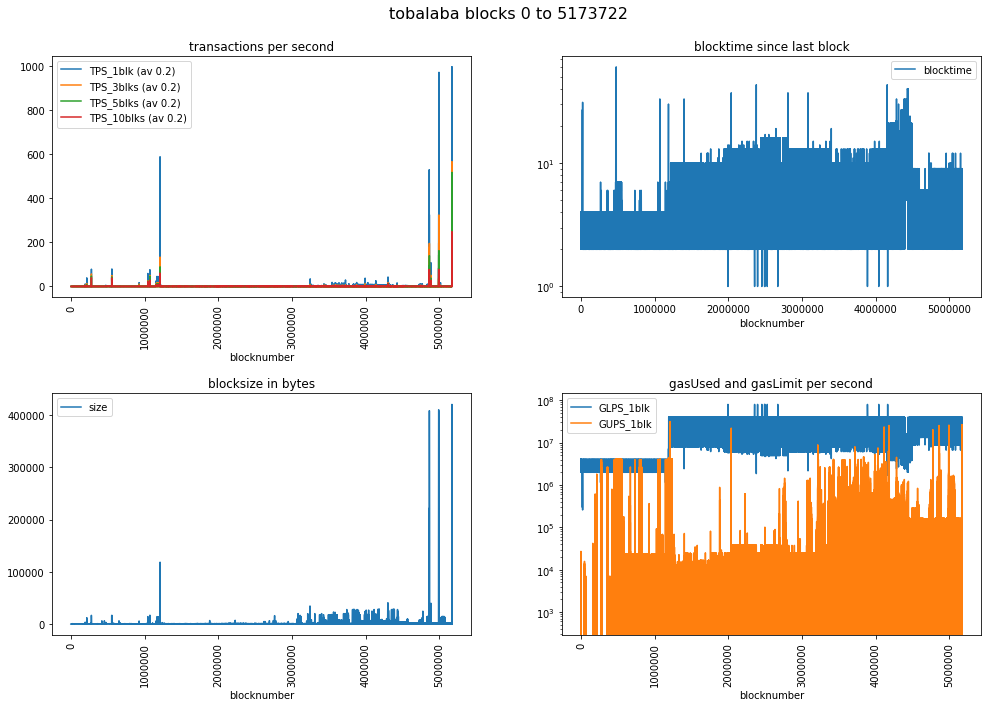

In [ ]:
# the whole range of blocks

diagrams(df, 0, len(blocknumbers)-1, NAME_PREFIX, gas_logy=True, bt_logy=True)

## whole chain DB, TPS plotted logarithmic

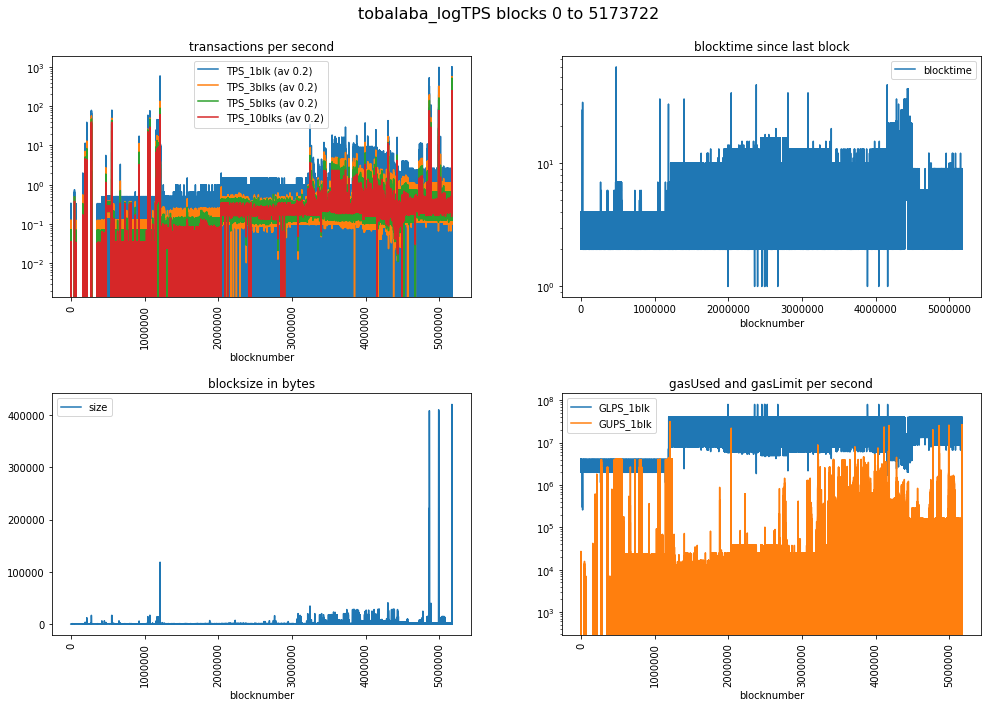

In [ ]:
# the whole range of blocks

diagrams(df, 0, len(blocknumbers)-1, NAME_PREFIX+"_logTPS", gas_logy=True, bt_logy=True, tps_logy=True)

## zooming in
## my own experiment, 10,000 tx in blocks 5172065 ...


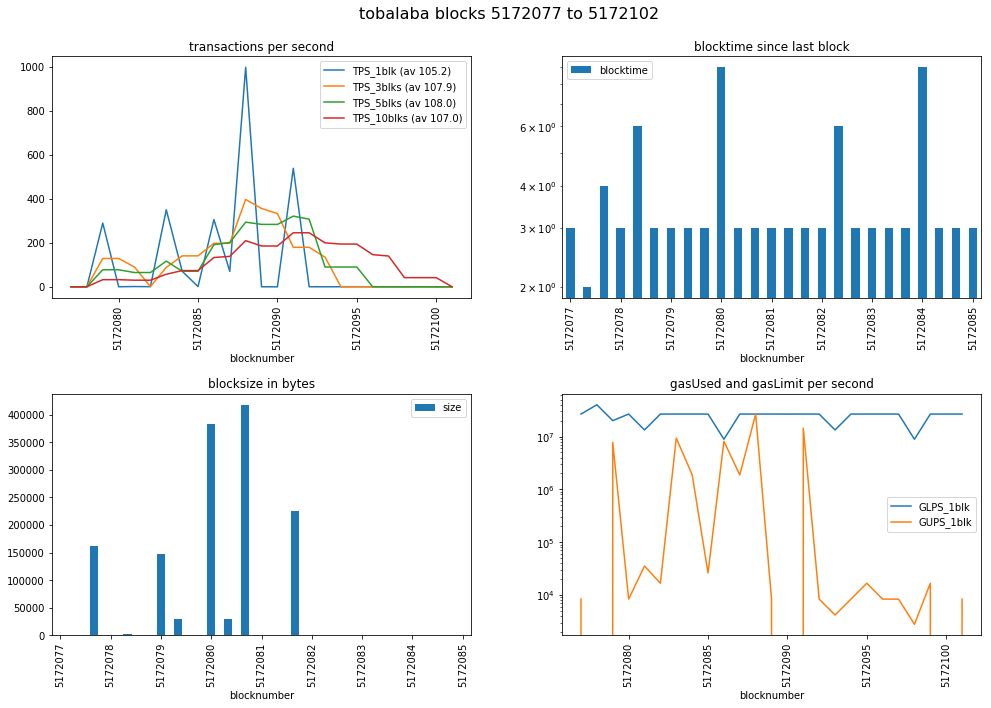

In [ ]:
# zooming in

diagrams(df, 5172077, 5172102, NAME_PREFIX, gas_logy=True, bt_logy=True)

In [ ]:
## zooming in
## my own experiment: 20,000 tx in blocks 5173632 ...



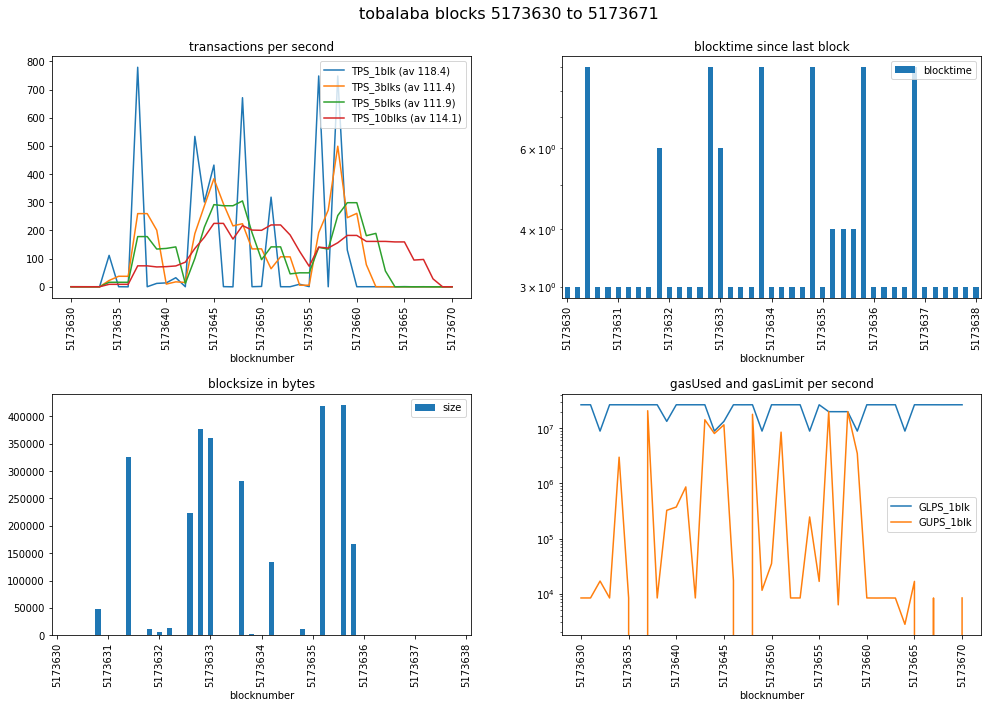

In [ ]:
# zooming in

diagrams(df, 5173630, 5173671, NAME_PREFIX, gas_logy=True, bt_logy=True)